# Laborator 6 - Clasificarea imaginilor

**Clasificarea imaginilor** este o sarcină fundamentală în domeniul învațării automate și al viziunii computerizate (computer vision), cu numeroase aplicații practice - de la recunoașterea scrisului de mână și a plăcuțelor de înmatriculare, până la clasificarea fotografiilor sau recunoașterea facială. În esență, clasificarea imaginilor presupune antrenarea unui model care poate primi o imagine ca intrare și poate prezice eticheta corespunzătoare (de exemplu, ce cifră sau obiect apare în imagine).


În acest laborator, vom aborda o problemă clasică: recunoașterea cifrelor scrise de mână folosind un set de date binecunoscut (**MNIST**). Vom parcurge același flux ca în laboratoarele anterioare:

1.   Încărcarea datelor - vom folosi dataset-ul MNIST, care conține imagini cu cifre 0-9 scrise de mână.
2.   Explorarea datelor - vom examina formatul datelor, distribuția etichetelor și vom vizualiza exemple de imagini.
3. Preprocesarea - vom pregăti datele pentru model.
4. Construirea unui model de clasificare - vom defini un model simplu folosind biblioteca *scikit-learn*.
5. Antrenarea modelului și evaluarea performanței - vom antrena modelul pe imagini și vom măsura acuratețea acestuia pe date de test.

În plus, în acest laborator, vom crea și o interfață interactivă cu **Gradio**, care va permite desenarea sau încărcarea unei imagini cu o cifră, pentru ca modelul antrenat să facă predicții în timp real.

## Încărcarea setului de date de imagini (MNIST)

**MNIST** (Modified National Institute of Standards and Technology database) este un set de date clasic folosit pentru probleme de recunoaștere a cifrelor scrise de mână.

Dataset-ul conține imagini alb-negru (tonuri de gri) de dimensiune 28x28 pixeli, fiecare imagine reprezentând o cifră între 0 și 9. În total, MNIST include *70.000* de imagini. Fiecare pixel are o valoare între 0 și 255 (0 corespondând culorii negru și 255 alb, cifrele fiind de obicei reprezentate cu pixeli albi pe fundal negru).


Pentru a încărca acest set de date în Python, putem folosi fie utilitarul *fetch_openml* din scikit-learn și vom împărți datele în set de antrenament și test.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# Încărcăm dataset-ul MNIST (toate cele 70.000 imagini)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int32)

# Împărțim automat 60.000 pentru antrenament, 10.000 pentru test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


După rularea codului, variabilele vor conține:

* X_train - un array NumPy cu dimensiunea (60000, 784), unde fiecare rând reprezintă o imagine aplatizată 28x28 = 784 pixeli.
* y_train - un array cu 60.000 de etichete (întregi între 0 și 9), corespunzătoare imaginilor de antrenament.
* X_test - un array cu dimensiunea (10000, 784), imagini de test aplatizate.
* y_test - un array cu 10.000 de etichete pentru imaginile de test.

## Explorarea și înțelegerea datelor

Înainte de a antrena un model, este important să explorăm datele pentru a înțelege mai bine problema. Vom avea în vedere câteva aspecte de bază:
* Exemple de imagini și etichete: vom afișa câteva imagini din setul de date, împreună cu etichetele lor (cifra corectă), pentru a ne asigura că înțelegem ce conține dataset-ul.
* Distribuția claselor: vom verifica dacă toate cele 10 cifre apar în mod aproximativ echilibrat în datele de antrenament.

 Să afișăm câteva imagini din X_train. Vom folosi biblioteca Matplotlib pentru a vizualiza imagini. De exemplu, putem afișa primele 5 imagini din set și etichetele asociată acestora:

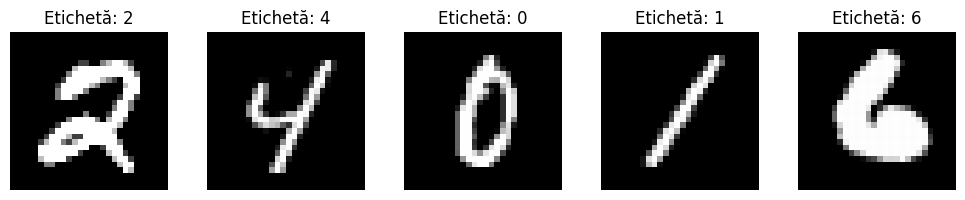

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Etichetă: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Vom verifica dacă datele de antrenament conțin un număr aproximativ egal de exemple pentru fiecare cifră de la 0 la 9. Ideal, dataset-ul ar trebui să fie echilibrat, pentru ca modelul să învețe fiecare clasă în mod similar. Putem folosi Pandas sau NumPy pentru a număra frecvența fiecărei etichete în *y_train* . De exemplu, folosind pandas:

In [3]:
import pandas as pd

labels, counts = np.unique(y_train, return_counts=True)
freq_series = pd.Series(counts, index=labels)
print(freq_series)

0    5920
1    6725
2    6023
3    6107
4    5918
5    5376
6    5915
7    6238
8    5856
9    5922
dtype: int64


**Observație!** Deoarece am folosit împărțire aleatoare, distribuția claselor în *y_train* nu este perfect uniformă. Acest lucru reflectă condiții mai realiste și permite modelului să învețe din date mai diverse.

 ## Preprocesarea imaginilor

În forma actuală, imaginile din *X_train* și *X_test* sunt stocate ca vectori unidimensionali de 784 de elemente, corespunzători pixelilor unei imagini 28x28. Acest format este specific funcției *fetch_openml('mnist_784')*, care returnează deja imaginile aplatizate.

Pentru a putea antrena un model de învățare automată clasic, vom realiza un singur pas important de preprocesare:
* **Normalizarea pixelilor**: Pixelii au valori între 0 și 255. Pentru a aduce toate caracteristicile la aceeași scară, vom împărți valorile la 255, obținând valori în intervalul [0, 1]. Această normalizare ajută algoritmii să învețe mai eficient și să evite dezechilibre numerice în calculul gradientului sau distanțelor.



In [4]:
# Convertim la float și normalizăm la [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("Valori pixel normalizate:", X_train.min(), "->", X_train.max())

Valori pixel normalizate: 0.0 -> 1.0


**Observație!** Dacă am lucra cu un model de rețea neurală convoluțională (CNN), am păstra imaginile în forma lor 2D (28, 28) și nu le-am aplatiza. Însă, algoritmii clasici din scikit-learn (regresie, SVM, arbori de decizie etc.) necesită vectori de caracteristici și nu pot lucra direct cu imagini 2D.

## Construirea unui model de clasificare

 Pentru clasificarea cifrelor, vom începe cu un model de bază: **Regresia Logistică**. Regresia logistică este un algoritm liniar de clasificare care, în varianta *multiclass*, poate fi folosit pentru a distinge
 între mai multe clase (în cazul nostru, 10 clase). Practic, modelul va învăța 10 seturi de coeficienți (câte unul pentru fiecare cifră 0-9) astfel încât să calculeze scoruri pentru fiecare clasă; predicția finală va fi clasa cu
 scorul cel mai mare.

In [5]:
from sklearn.linear_model import LogisticRegression

# Inițializăm modelul de regresie logistică
model = LogisticRegression(max_iter=1000)

Am setat *max_iter=1000* pentru a permite algoritmului de optimizare să facă până la 1000 de iterații în încercarea de a converge la o soluție (implicit erau 100; pe un set mare ca MNIST, 100 ar putea fi insuficient și am primi un warning de convergență).

## Antrenarea modelului

Acum că avem modelul definit și datele pregătite, următorul pas este antrenarea efectivă a modelului pe datele de antrenament. Antrenarea presupune ca modelul să învețe din exemple - în cazul regresiei logistice, se vor ajusta coeficienții astfel încât să prezică corect cât mai multeimagini.

In [6]:
# Antrenarea modelului pe datele de antrenament
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**Atenție!** Antrenarea pe întreg setul MNIST (60k imagini, 784 trăsături fiecare) poate dura câteva zeci de secunde până la câteva minute, în funcție de resursele puse la dispoziție. În mod normal, logistic regression va rula pe CPU.

## Evaluarea performanței modelului

Pentru a evalua cât de bine a învățat modelul să recunoască cifrele, vom folosi setul de test (care conține imagini care nu au fost văzute de model în timpul antrenamentului). Vom prezice etichetele pentru imaginile de test și vom compara predicțiile cu etichetele reale.

Cea mai simplă **metrică** de evaluare pentru clasificare este **acuratețea** (accuracy), definită ca proporția de exemple pentru care modelul a nimerit clasa corectă.

În cazul nostru, acuratețea = (număr de imagini de test clasificate corect) / (număr total imagini de test). Vom calcula această valoare. Ideal, ne dorim o acuratețe cât mai aproape de 1 (sau 100%).

In [7]:
from sklearn.metrics import accuracy_score

# Prezicem etichetele pentru imaginile de test
y_pred = model.predict(X_test)

# Calculăm acuratețea comparând predicțiile cu etichetele reale
acc = accuracy_score(y_test, y_pred)
print(f"Acuratețea pe setul de test: {acc:.4f}")

Acuratețea pe setul de test: 0.9202


 Pentru a înțelege unde face modelul greșeli, vom calcula matricea de confuzie
 O **matrice de confuzie** este o tabelă N x N (în cazul nostru 10x10, N=10 clase) în care pe linia i și coloana j se află numărul de exemple din clasa reală i pe care modelul le-a prezis ca fiind clasa j. Diagonala principală conține predicțiile corecte (clasă prezisă = clasă reală).

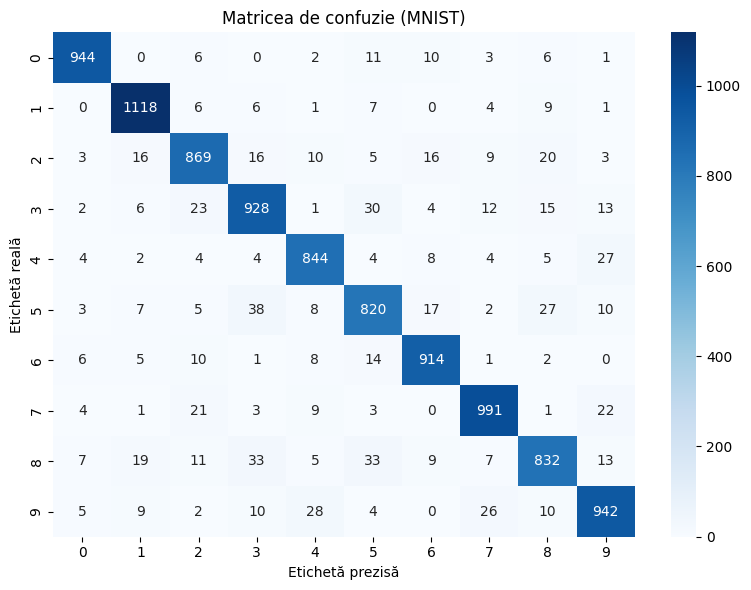

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculează matricea de confuzie
cm = confusion_matrix(y_test, y_pred)

# Listează clasele ca șiruri (pentru etichete clare)
labels = [str(i) for i in range(10)]

# Creează figura
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Etichetă prezisă')
plt.ylabel('Etichetă reală')
plt.title('Matricea de confuzie (MNIST)')
plt.tight_layout()
plt.show()

## Crearea unei interfețe interactive cu Gradio

Acum vine partea interactivă și distractivă. Vom crea o mică aplicație web care permite oricui să deseneze de mână o cifră și să obțină predicția modelului nostru în timp real. Vom folosi biblioteca Gradio pentru a construi această interfață foarte ușor, direct din notebook.

**Gradio** este o bibliotecă open-source care permite crearea de interfețe grafice web simple pentru modele de ML cu efort minim. Practic, putem lega o funcție Python (care face predicția cu modelul nostru) la o interfață de tip "desen" sau "imagine" ca input și un text sau label ca output, iar Gradio se ocupă de restul - ne oferă un UI web unde putem interacționa cu modelul.

 În mediul Colab, trebuie să instalăm Gradio și apoi să îl importăm în proiect. Putem face acest lucru astfel:

In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [10]:
import gradio as gr

Gradio are nevoie de o funcție specială pe care să o apeleze ori de câte ori utilizatorul oferă o imagine nouă. Această funcție va primi imaginea ca parametru și trebuie să returneze predicția modelului.

În cazul nostru, funcția trebuie să facă următorii pași:
1. Primește imaginea sub formă de array NumPy bidimensional, cu dimensiunea 28x28 (alb-negru), furnizată automat de Gradio.
2. Preprocesează imaginea exact ca în setul de testare:
  * o aplatizează într-un vector de 784 valori;
  * o normalizează la intervalul [0, 1].
3. Aplică modelul antrenat (model.predict) pentru a obține eticheta prezisă.
4. Returnează eticheta sub formă de int sau str (între 0 și 9).

In [47]:
def predict_digit(img):
    img_flat = img.reshape(1, 784).astype('float32')
    pred = model.predict(img_flat)[0]
    return int(pred)

Înainte de a conecta modelul la o interfață Gradio, este o bună practică să verificăm dacă funcția definită funcționează corect. Putem face acest lucru testând-o pe o imagine cunoscută din X_test și comparând rezultatul cu apelul direct *model.predict(...)*.

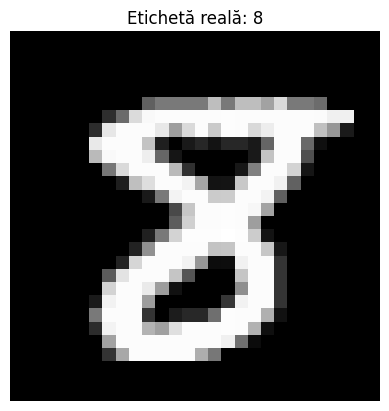

Predicție folosind predict_digit: 8
Predicție folosind model.predict: 8


In [48]:
import matplotlib.pyplot as plt

# Afișăm prima imagine din X_test pentru verificare
plt.imshow(X_test[0].reshape(28, 28), cmap='gray')
plt.title(f"Etichetă reală: {y_test[0]}")
plt.axis('off')
plt.show()

# Apelăm funcția personalizată
print("Predicție folosind predict_digit:", predict_digit(X_test[0].reshape(28, 28)))

# Comparație cu predicția directă
print("Predicție folosind model.predict:", model.predict(X_test[0].reshape(1, 784))[0])

Acum vom folosi clasa gr.Interface pentru a defini interfața interactivă. Trebuie să specificăm:

* **fn** - funcția care realizează predicția (în cazul nostru, predict_digit - cu anumite modificări astfel încât imaginea primită să aibă proprietățile imaginilor din setul de antrenament).

* **inputs** - tipul de input așteptat. Folosim componenta *gr.Sketchpad()*, care oferă o pânză digitală pe care utilizatorul poate desena o cifră. Aceasta returnează imaginea completă desenată sub forma unui dicționar ce conține cheia "composite", adică imaginea finală combinată.

* **outputs** - tipul de output. Deoarece dorim să afișăm un rezultat textual („Predicție: 3” de exemplu), folosim "text" sau gr.Label() ca tip de ieșire.

Pentru a obține predicții corecte, imaginea desenată trece printr-un proces de preprocesare care simulează aspectul cifrelor din MNIST:

* Imaginea este convertită la tonuri de gri și inversată pentru a avea fundal negru și cifră albă.

* Se face un crop automat la zona utilă (bounding box), pentru a elimina spațiul gol.

* Cifra este redimensionată și centrată într-un canvas de 28x28 pixeli, conform formatului standard MNIST.

* Valorile pixelilor sunt normalizate între 0 și 1, apoi imaginea este aplatizată într-un vector de dimensiune 784, așa cum a fost modelul antrenat.


**Observație!** Pentru rezultate mai bune, încercați să desenați cifra pe toată suprafața canvas-ului.

In [53]:
import gradio as gr
import numpy as np
from PIL import Image, ImageOps

def center_and_resize(img):
    # Crop la bounding box
    img = ImageOps.invert(img)
    bbox = img.getbbox()
    img = img.crop(bbox)
    img = ImageOps.invert(img)

    # Redimensionăm într-un canvas 28x28 și centrăm
    img = img.resize((20, 20), Image.Resampling.LANCZOS)
    new_img = Image.new("L", (28, 28), 0)
    new_img.paste(img, (4, 4))
    return new_img

def predict_digit(img):
    try:
        img = img["composite"]
        img = Image.fromarray(img[..., :3]).convert("L")
        img = ImageOps.invert(img)  # fundal negru, cifră albă
        img = center_and_resize(img)

        img_np = np.array(img)
        img_flat = img_np.reshape(1, 784) / 255.0

        pred_class = model.predict(img_flat)[0]
        proba = model.predict_proba(img_flat)[0]

        return f"Predicție: {pred_class}"

    except Exception as e:
        return f"Eroare: {str(e)}"

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(),
    outputs="text",
    title="Recunoaștere cifre scrise de mână",
    description="Desenează o cifră și apasă Submit"
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ce770bfbb7f0d83241.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Exerciții

În această parte a laboratorului, vom antrena un model CNN (Convolutional Neural Network) folosind PyTorch, pe același set de date MNIST ca în prima parte.

## Încărcarea datelor
- Încărcăm setul MNIST de pe OpenML.
- Convertim etichetele în întregi (`int64`).
- Împărțim în date de antrenament și test: 60.000 pentru antrenare și 10.000 pentru test.

In [54]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


## Preprocesarea datelor pentru PyTorch
- Reshape la formatul (număr_imagini, 1, 28, 28) - adică adăugăm dimensiunea canalului (alb-negru).
- Normalizăm valorile pixelilor în [0, 1].
- Creăm tensori pentru inputuri și etichete.
- Construim `DataLoader` pentru a putea parcurge datele în batch-uri.

In [55]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 28, 28), dtype=torch.float32) / 255.0
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 28, 28), dtype=torch.float32) / 255.0
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

## Definirea modelului CNN
- Definim o clasă `SimpleCNN` care extinde `nn.Module` (tipic pentru PyTorch);
- Adăugăm două straturi convoluționale cu activări ReLU și pooling între ele;
- Aplatizăm rezultatul (flatten);
- Adăugăm două straturi complet conectate (dense);
- Ieșirea finală are 10 neuroni - unul pentru fiecare cifră posibilă.


In [57]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = SimpleCNN()

## Antrenarea modelului CNN
- Definim funcția de pierdere (`CrossEntropyLoss`) și optimizatorul (`Adam`);
- Rulăm un loop de antrenare pe 5 epoci;
- La fiecare batch, calculăm loss-ul și facem backpropagation.

In [60]:
import torch.optim as optim

device = "cpu"
model_cnn.to("cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

for epoch in range(5):
    model_cnn.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoca {epoch+1} – Loss: {running_loss / len(train_loader):.4f}")

Epoca 1 – Loss: 0.1916
Epoca 2 – Loss: 0.0866
Epoca 3 – Loss: 0.0616
Epoca 4 – Loss: 0.0495
Epoca 5 – Loss: 0.0388


## Evaluarea performanței pe setul de test
- Trecem modelul în modul *eval()* pentru inferență;
- Oprim calculul gradientului (*torch.no_grad()*);
- Calculăm acuratețea pe tot setul de test.

In [65]:
model_cnn.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Acuratețea CNN pe setul de test: {correct / total:.4f}")

Acuratețea CNN pe setul de test: 0.9846
Acuratețea CNN pe setul de test: 0.9846


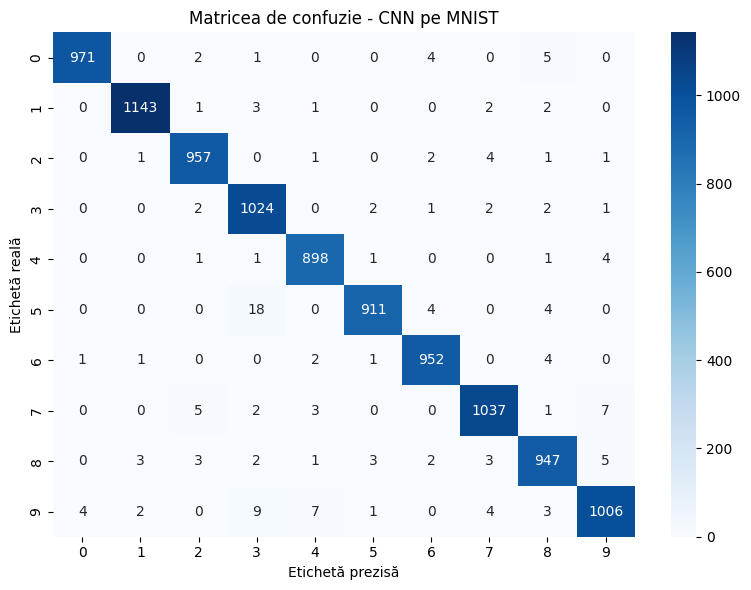

In [66]:
# Matricea de confuzie
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel("Etichetă prezisă")
plt.ylabel("Etichetă reală")
plt.title("Matricea de confuzie - CNN pe MNIST")
plt.tight_layout()
plt.show()

## Integrarea modelului cu Gradio

- Creăm o funcție *predict_digit_cn* care primește imaginea desenată;
- Redimensionăm la 28x28, convertim în alb-negru, inversăm culorile și normalizăm imaginea;
- Transformăm imaginea într-un tensor compatibil cu PyTorch;
- Modelul CNN face predicția, iar rezultatul este returnat în interfață.

In [67]:
import gradio as gr
from PIL import Image

def predict_digit_cnn(img):
    try:
        img = img["composite"]
        img_pil = Image.fromarray(img).convert("L").resize((28, 28), Image.Resampling.LANCZOS)
        img_np = 255 - np.array(img_pil)
        img_tensor = torch.tensor(img_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

        model_cnn.eval()
        with torch.no_grad():
            output = model_cnn(img_tensor.to(device))
            prediction = torch.argmax(output, dim=1).item()

        return f"Predicție CNN: {prediction}"
    except Exception as e:
        return f"Eroare: {str(e)}"

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(),
    outputs="text",
    title="Recunoaștere cifre scrise de mână",
    description="Desenează o cifră și apasă Submit"
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://367b36a3711d6970e9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
